In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from torchvision import datasets

In [3]:
data_path ='../data-unversioned/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

In [4]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [5]:
len(cifar10)

50000

In [6]:
img, label = cifar10[123]
img, label, cifar10.classes[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x1E4797B2520>, 2, 'bird')

In [7]:
from matplotlib import pyplot as plt

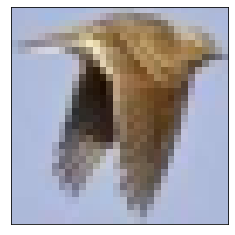

In [8]:
plt.imshow(img)
plt.xticks(())
_ = plt.yticks(())

In [9]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [10]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [11]:
del cifar10

In [12]:
img_t, _ = tensor_cifar10[123]

In [13]:
type(img_t)

torch.Tensor

In [14]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [15]:
img_t.min(), img_t.max()

(tensor(0.0039), tensor(0.9529))

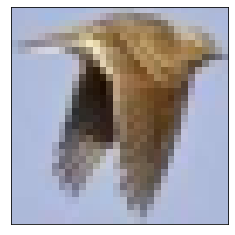

In [16]:
plt.imshow(img_t.permute(1, 2, 0))
plt.xticks(())
_ = plt.yticks(())

In [17]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)

In [18]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [19]:
means = imgs.reshape(3, -1).mean(dim=1)
means

tensor([0.4914, 0.4822, 0.4465])

In [20]:
stds = imgs.view(3, -1).std(dim=1)
stds

tensor([0.2470, 0.2435, 0.2616])

In [21]:
normalize = transforms.Normalize((.4915, .4823, .4468), (.2470, .2435, .2616))

In [27]:
transformed_cifar10 = datasets.CIFAR10(data_path,
                                       train=True,
                                       download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           normalize
                                       ]))

transformed_cifar10_v = datasets.CIFAR10(data_path,
                                         train=False,
                                         download=False,
                                         transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         normalize
                                       ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


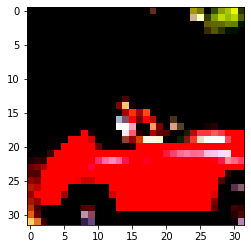

In [28]:
plt.imshow(transformed_cifar10[99][0].permute(1, 2, 0))

In [31]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar_val = [(img, label_map[label]) for img, label in transformed_cifar10_v if label in [0, 2]]


In [32]:
cifar2.__len__(), cifar_val.__len__()

(10000, 2000)

In [33]:
n_out = 2

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out)
)

In [34]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [35]:
softmax(torch.tensor([1, 2, 3]))

tensor([0.0900, 0.2447, 0.6652])

In [36]:
torch.exp(torch.tensor([1, 2, 3]))

tensor([ 2.7183,  7.3891, 20.0855])

In [37]:
softmax = nn.Softmax(dim=1)
x = torch.tensor([[1., 2., 3.], 
                  [1., 2., 3.]])
softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [38]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


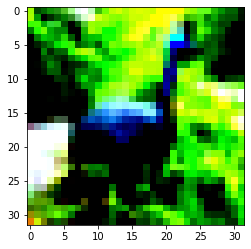

In [39]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))

In [40]:
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

torch.Size([1, 3072])

In [41]:
out = model(img_batch)
out

tensor([[0.6319, 0.3681]], grad_fn=<SoftmaxBackward>)

In [42]:
_, index = torch.max(out, dim=1)
_, index

(tensor([0.6319], grad_fn=<MaxBackward0>), tensor([0]))

In [43]:
index = torch.max(out, dim=1)
index

torch.return_types.max(
values=tensor([0.6319], grad_fn=<MaxBackward0>),
indices=tensor([0]))

In [141]:
import torch.optim

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.MSELoss()

learning_rate = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
data_train = DataLoader(cifar2, batch_size=64, shuffle=True)

In [184]:
from torch.utils.data import DataLoader

n_epochs = 20
for epoch in range(n_epochs):
    for imgs, labels in data_train:
        batch_size = imgs.shape[0]
        out = model(imgs.view(batch_size, -1))
        new_label = torch.zeros(batch_size, 2)
        new_label.scatter_(1, labels.unsqueeze(1), 1)
        loss = loss_fn(out, new_label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch:3} - loss {loss.item():4f}')

epoch:   0 - loss 0.001042
epoch:   1 - loss 0.024364
epoch:   2 - loss 0.128988
epoch:   3 - loss 0.001668
epoch:   4 - loss 0.004688
epoch:   5 - loss 0.002033
epoch:   6 - loss 0.064982
epoch:   7 - loss 0.002423
epoch:   8 - loss 0.004909
epoch:   9 - loss 0.005553
epoch:  10 - loss 0.000231
epoch:  11 - loss 0.003513
epoch:  12 - loss 0.001243
epoch:  13 - loss 0.003777
epoch:  14 - loss 0.003770
epoch:  15 - loss 0.002607
epoch:  16 - loss 0.000252
epoch:  17 - loss 0.001762
epoch:  18 - loss 0.002649
epoch:  19 - loss 0.064563


In [61]:
rand_img, _ = cifar2[123]
model(rand_img.ravel().unsqueeze(0))

tensor([[-5.5345e+00, -3.9559e-03]], grad_fn=<LogSoftmaxBackward>)

In [278]:
val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, -1)
        total += batch_size
        correct += int((predicted == labels).sum())
print('accuracy: ', correct/total)
print(correct, total)

accuracy:  0.8095
1619 2000


In [93]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list)

3672578

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


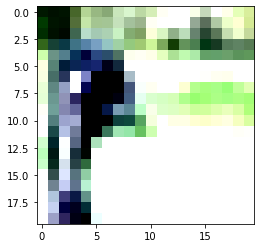

In [124]:
plt.imshow(transforms.RandomCrop((20, 20))(cifar2[10][0]).permute(1, 2, 0))

In [136]:
nn.MSELoss()(nn.Softmax(dim=1)(torch.tensor([[1.,2.,3.],
                                             [10.,4.,5.]])), torch.tensor([1,2,3]))

tensor(3.7184)